# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dropout, ReLU, MaxPool2D, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
import cv2

import os
from tqdm.notebook import tqdm
tqdm.pandas()

import cv2
import imghdr
from struct import unpack

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [3]:
data_dir = '../Dataset/flower_images/' 

In [ ]:
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break   

bads = []
for image_class in tqdm(os.listdir(data_dir)): 
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
        image_path = os.path.join(data_dir, image_class, image)
        image = JPEG(image_path) 
        try:
            image.decode()   
        except:
            bads.append(image_path)  

print(len(bads))

# for name in bads:
#     os.remove(os.path.join(name))


In [ ]:
image_exts = ['jpeg','jpg', 'png']

for image_class in tqdm(os.listdir(data_dir)): 
    print(image_class)
    for image in tqdm(os.listdir(os.path.join(data_dir, image_class))):
        image_path = os.path.join(data_dir, image_class, image)

        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)

        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# 3. Load Data

In [4]:
data = image_dataset_from_directory('../Dataset/flower_images/', batch_size = 32, label_mode='categorical', image_size=(227,227))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()


Found 4999 files belonging to 5 classes.


c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


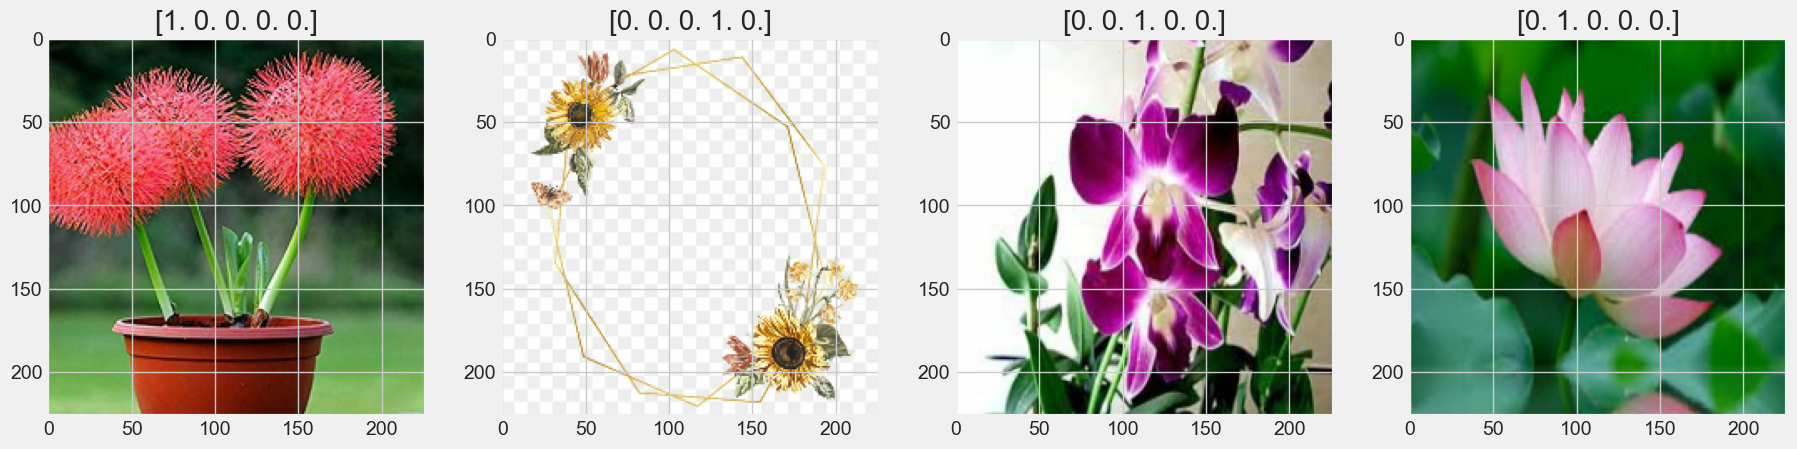

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [6]:
data = data.map(lambda x,y: (x/255, y))

# 5. Split Data

In [7]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

print(train_size)
print(val_size)
print(test_size)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

109
31
15


# 6. Build Deep Learning Model

In [18]:
model = Sequential()
model.add(Conv2D(input_shape=(112,112,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))

model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate = 0.000_1)

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 112, 112, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 28, 28, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 256)       295168    
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 256)      

In [14]:
### Alexnet Algoritms

model = keras.Sequential()
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation="relu", input_shape=(227, 227, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides= (2, 2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(5, activation="softmax"))

model.compile(loss='categorical_crossentropy', 
            optimizer=Adam(lr=0.000_01), 
            metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                                
                                                      

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(224,224,3)))
model.add(Conv2D(filters=16,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.9))
model.add(BatchNormalization())

model.add(Conv2D(filters=32,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation= 'relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())


model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=64,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())

model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.75))
model.add(BatchNormalization())

# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01)))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.75))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1000, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate = 0.001)

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
# model = Sequential()

# model.add(Conv2D(128, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same',  input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(64, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# model.add(MaxPooling2D())
# model.add(Dropout(0.4))
# model.add(BatchNormalization())

# # model.add(Conv2D(32, (3,3), 1, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
# # model.add(MaxPooling2D())
# # model.add(Dropout(0.4))
# # model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# # model.add(Dense(256, activation='relu'))
# # model.add(Dropout(0.2))

# model.add(Dense(4, activation='softmax'))

# opt = Adam(learning_rate = 0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy()

# model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(112,112,3)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(Dropout(0.8))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, kernel_regularizer=keras.regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate = 0.0001)

model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# 7. Train

In [15]:
epoch = 10

hist = model.fit(train, epochs=epoch, validation_data=val)

Epoch 1/10
109/109 [==============================] - 14s 116ms/step - loss: 2.2022 - accuracy: 0.4166 - val_loss: 1.6049 - val_accuracy: 0.2077
Epoch 2/10
109/109 [==============================] - 13s 115ms/step - loss: 1.2907 - accuracy: 0.5932 - val_loss: 1.6021 - val_accuracy: 0.1986
Epoch 3/10
109/109 [==============================] - 13s 114ms/step - loss: 0.8860 - accuracy: 0.6901 - val_loss: 1.5099 - val_accuracy: 0.3276
Epoch 4/10
109/109 [==============================] - 13s 115ms/step - loss: 0.6354 - accuracy: 0.7741 - val_loss: 1.3523 - val_accuracy: 0.4516
Epoch 5/10
109/109 [==============================] - 13s 115ms/step - loss: 0.5118 - accuracy: 0.8197 - val_loss: 0.8517 - val_accuracy: 0.6754
Epoch 6/10
109/109 [==============================] - 13s 114ms/step - loss: 0.3963 - accuracy: 0.8564 - val_loss: 0.6570 - val_accuracy: 0.7681
Epoch 7/10
109/109 [==============================] - 13s 114ms/step - loss: 0.3187 - accuracy: 0.8868 - val_loss: 0.5356 - val_ac

# 8. Plot Performance

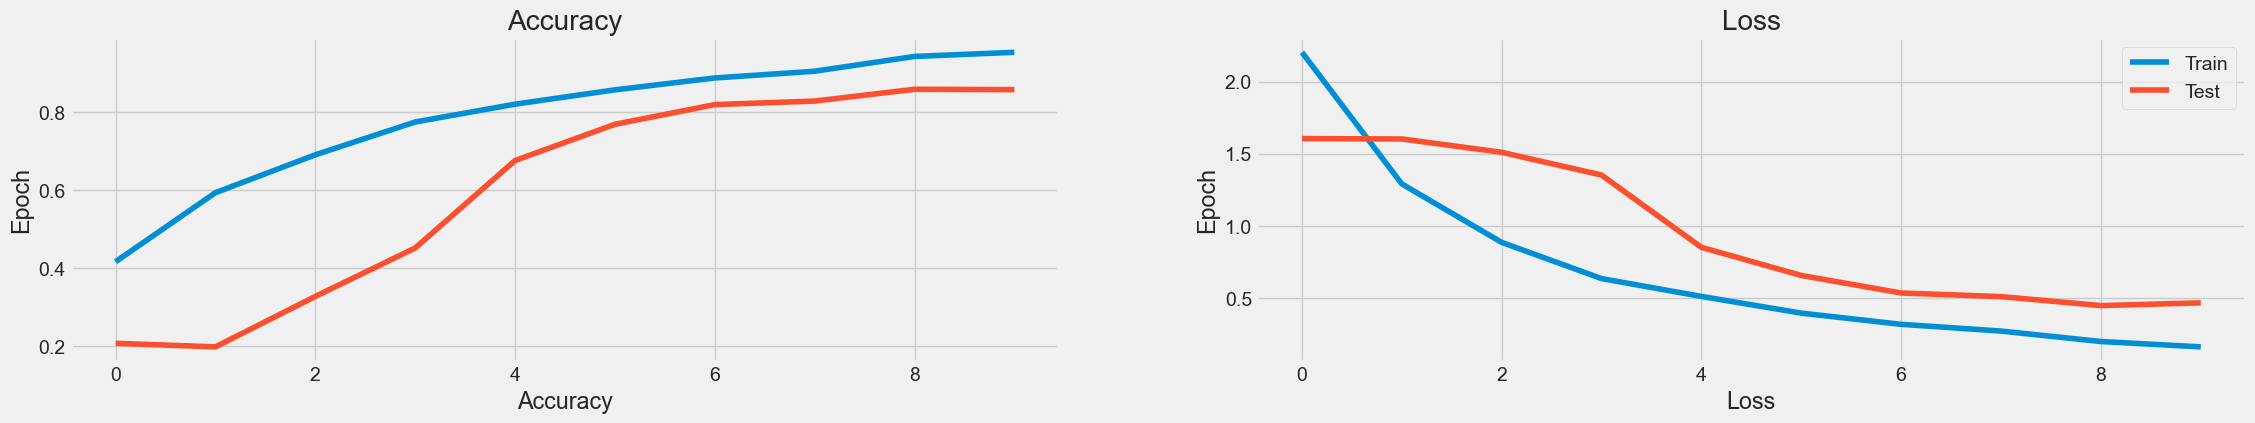

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

# 9. Evaluate

In [18]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X, verbose = 0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f"Precision       : {pre.result().numpy()}")
print(f"Recall          : {re.result().numpy()}")
print(f"Binary Accuracy : {acc.result().numpy()}")


Precision       : 0.8392857313156128
Recall          : 0.7833333611488342
Binary Accuracy : 0.9266666769981384


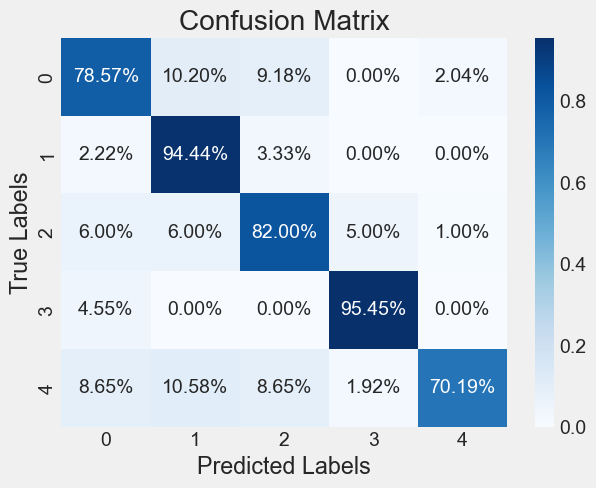

In [19]:
labels = []

label_pred,label_true = [], []
for batch in test.as_numpy_iterator(): 
    X, Y = batch
    pred = model.predict(X, verbose=0)
    label_pred.append(pred.argmax(axis=1))
    label_true.append(Y.argmax(axis=1))

label_true = np.concatenate(label_true).tolist()
label_pred = np.concatenate(label_pred).tolist()

con_mat = confusion_matrix(label_true, label_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 10. Test

In [ ]:
img_load = cv2.imread('TestImages/2021-08-18_12-42-27_UTC_2.jpg')
img = cv2.cvtColor(img_load, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
pred = yhat.argmax()

# 11. Save the Model

In [37]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('models/imageclassifier.h5')
pred_model = new_model.predict(np.expand_dims(resize/255, 0))
label = pred_model.argmax()